<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/08_Self_Supervised_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: oguiza@timeseriesAI.co

# MVP (previously TSBERT): Self-Supervised Pretraining of Time Series Models 🤗

This is an unofficial PyTorch implementation created by Ignacio Oguiza (oguiza@timeseriesAI.co) based on:

* Zerveas, G., Jayaraman, S., Patel, D., Bhamidipaty, A., & Eickhoff, C. (2020). A Transformer-based Framework for Multivariate Time Series Representation Learning. arXiv preprint arXiv:2010.02803v2.. No official implementation available as far as I know (Oct 10th, 2020)

`MVP` is a self-supervised training method that can be used to pretrain time series models without using any labels. The approach is very similar to BERT.

`MVP` is performed in 2 steps: 

1. Pretrain the selected architecture without any labels. When training is finished, the pretrained model will be automatically saved to the given target_dir/fname.
2. Fine-tune or train the same architecture with pretrained=True indicating the weights_path (target_dir/fname).


In this notebook we'll use a UCR dataset (LSST) that contains around 2500 training and 2500 validation samples. To analyze the impact of `MVP` we'll:
1. use supervised learning to set a baseline using 10% or 100% of the labels.
2. pretrain a model using 100% of the training dataset without labels.
3. fine tune or train using 10% or 100% of the training dataset (with labels). 

A key difference between `MVP` and the original paper is that you can use any architecture of your choice as long as it has a "head" attribute and can take a custom_head kwarg. Architectures finished in Plus in the `tsai` library meet this criteria. To demonstrate how this works, we'll use InceptionTimePlus throughout this notebook.

### Results

<img src="https://github.com/timeseriesAI/tsai/blob/master/tutorial_nbs/images/TSBERT_data.jpg?raw=1">
<img src="https://github.com/timeseriesAI/tsai/blob/master/tutorial_nbs/images/TSBERT_chart.jpg?raw=1">

These results indicate the following: 

* Pretraining + fine-tuning/ training improves performance when compared to supervised learning (training from scratch).
* In this case, there's not much difference between fine-tuning and training a pretrained model. This may be dataset dependent. It'd be good to try both approaches. 
* The fewer labels available, the better pretraining seems to work. 

# Import libraries 📚

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [ ]:
from tsai.all import *
from IPython.display import clear_output
my_setup()

os              : Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic
python          : 3.7.15
tsai            : 0.3.5
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.12.1+cu113
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : [14.75] GB


# Prepare data 🏭

We'll first import the data.

In [ ]:
dsid = 'LSST'
X, y, splits = get_UCR_data(dsid, split_data=False)

We'll now create 2 dataloaders with 100% of the training and 100% of validation samples.
One of them doesn't contain the y (unlabeled). The other one contains the labels. 
We'll use the unlabeled dataset (udls) to pretrain the model.

X      - shape: [4925 samples x 6 features x 36 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (4925,)  type: memmap  dtype:<U2  n_classes: 14 (351 samples per class) ['15', '16', '42', '52', '53', '6', '62', '64', '65', '67', '88', '90', '92', '95']  isnan: False
splits - n_splits: 2 shape: [2459, 2466]  overlap: False


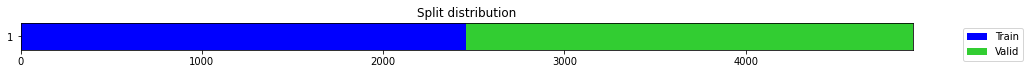

In [ ]:
# 100% train data
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
check_data(X, y, splits)
dls100 = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
udls100 = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms) # used in pretraining

We'll also need a labeled dataloaders with 10% of the training and 100% of validation data.

X      - shape: [4925 samples x 6 features x 36 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (4925,)  type: memmap  dtype:<U2  n_classes: 14 (351 samples per class) ['15', '16', '42', '52', '53', '6', '62', '64', '65', '67', '88', '90', '92', '95']  isnan: False
splits - n_splits: 2 shape: [245, 2466]  overlap: False


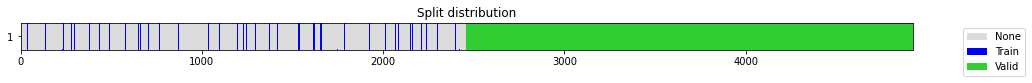

In [ ]:
# 10% train data
train_split010 = get_splits(y[splits[0]], valid_size=.1, show_plot=False)[1]
splits010 = (train_split010, splits[1])
check_data(X, y, splits010)
dls010 = get_ts_dls(X, y, splits=splits010, tfms=tfms, batch_tfms=batch_tfms)

# Supervised 👀

First we'll train a model in a supervised way to set a baseline. We'll train using 10% and 100% of the training set. We'll run 10 tests.

We'll train all models with the same settings (50 epochs with 10% of labels, 20 and 50 epochs with 100% of labels and lr=1e-2) to see the impact of pretraining.

9/10 accuracy: 0.551 +/- 0.012


epoch,train_loss,valid_loss,accuracy,time
0,2.392443,2.586974,0.158962,00:00
1,2.134207,2.550200,0.327656,00:00
2,1.900959,2.459302,0.412003,00:00
3,1.736904,2.291027,0.454988,00:00
4,1.595100,2.010056,0.385239,00:00
5,1.475684,1.724621,0.455393,00:00
6,1.366361,2.293169,0.342660,00:00
7,1.272244,2.615479,0.335766,00:00
8,1.214466,5.391157,0.311841,00:00
9,1.161470,5.862578,0.240876,00:00


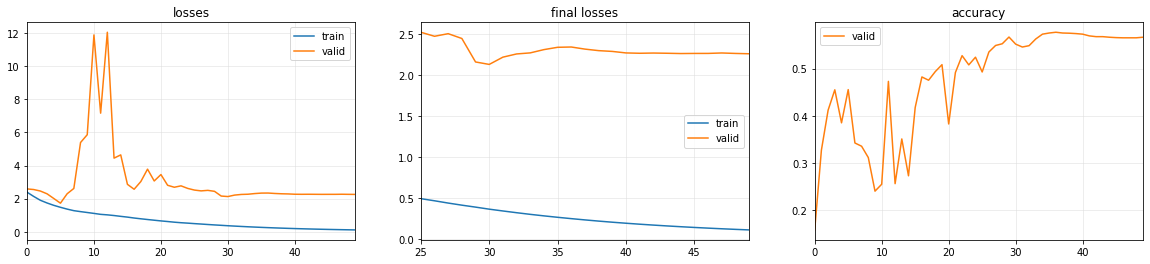


accuracy: 0.553 +/- 0.012 in 10 tests


In [ ]:
# supervised 10%
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.704 +/- 0.008


epoch,train_loss,valid_loss,accuracy,time
0,1.671537,1.498752,0.554745,00:01
1,1.322052,1.400467,0.517032,00:01
2,1.176284,1.243742,0.588402,00:01
3,1.072991,1.190321,0.600162,00:01
4,1.012279,1.415337,0.556367,00:01
5,0.960235,1.495342,0.550284,00:01
6,0.954449,1.213503,0.580697,00:01
7,0.915740,1.321159,0.546229,00:01
8,0.893450,1.147034,0.605434,00:01
9,0.837598,1.275555,0.646391,00:01


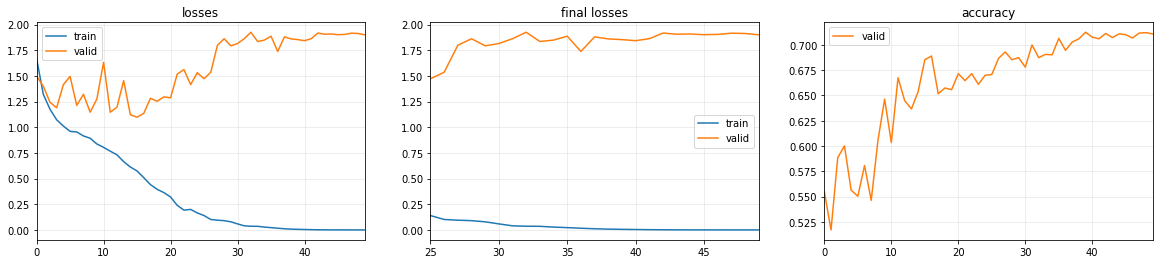


accuracy: 0.705 +/- 0.008 in 10 tests


In [ ]:
# supervised 100%
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

I've also trained the model with all labels for 20 as it seems to be overfitting with 50 epochs.

9/10 accuracy: 0.704 +/- 0.007


epoch,train_loss,valid_loss,accuracy,time
0,1.624283,1.242335,0.599351,00:01
1,1.308659,1.309413,0.581103,00:01
2,1.195383,1.460219,0.534874,00:01
3,1.132420,1.444884,0.548662,00:01
4,1.064421,1.276374,0.607056,00:01
5,1.002132,1.137723,0.639903,00:01
6,0.940965,1.056402,0.678021,00:01
7,0.876387,1.136045,0.636253,00:01
8,0.807043,1.142451,0.656123,00:01
9,0.753507,0.975970,0.671533,00:01


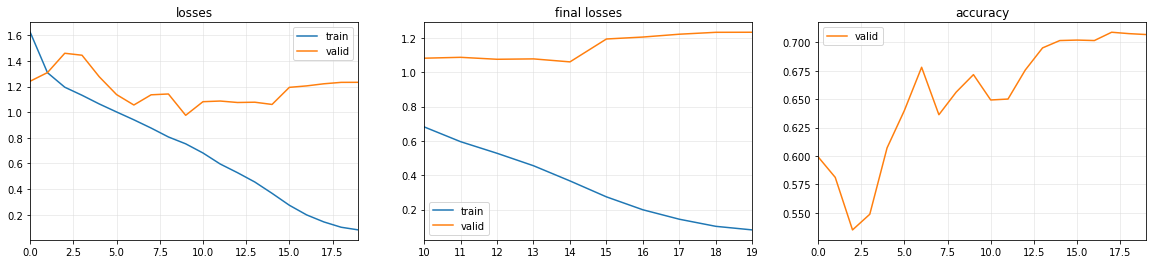


accuracy: 0.704 +/- 0.007 in 10 tests


In [ ]:
# supervised 100%
n_epochs = 20
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

This is a great result. Just for reference, in a recent review of multivariate time series models (Ruiz, A. P., Flynn, M., Large, J., Middlehurst, M., & Bagnall, A. (2020). The great multivariate time series classification bake off: a review and experimental evaluation of recent algorithmic advances. Data Mining and Knowledge Discovery, 1-49.), the best performing classifier on this dataset is MUSE with an accuracy of **63.62**. 

Let's see if we can improve our baseline pretraining InceptionTime using `MVP`.

# Pretrain model  🏋️‍♂️

Now we'll train a model without any labels on the entire training set. To do that we need to use the `MVP` callback. You can get more details on this callback visiting [`tsai` documentation](https://timeseriesai.github.io/tsai/callback.MVP).

epoch,train_loss,valid_loss,time
0,0.878598,0.736160,00:01
1,0.771231,0.656394,00:01
2,0.696442,0.644376,00:01
3,0.652715,0.576550,00:01
4,0.620771,0.582425,00:01
5,0.599180,0.569920,00:01
6,0.588546,0.541254,00:01
7,0.577152,0.554392,00:01
8,0.572752,0.552466,00:01
9,0.570101,0.535399,00:01


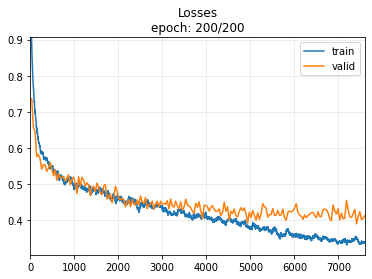


epochs: 200 best epoch: 194  val_loss: 0.390507 - pretrained weights_path='data/MVP/LSST_200.pth'



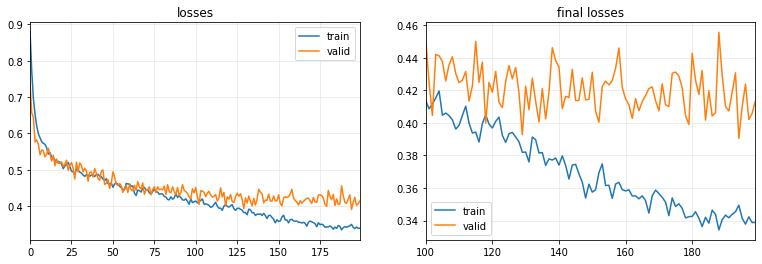

In [ ]:
# Unlabeled 100%
learn = ts_learner(udls100, InceptionTimePlus, cbs=[ShowGraph(), MVP(target_dir='./data/MVP', fname=f'{dsid}_200')])
learn.fit_one_cycle(200, 1e-2)

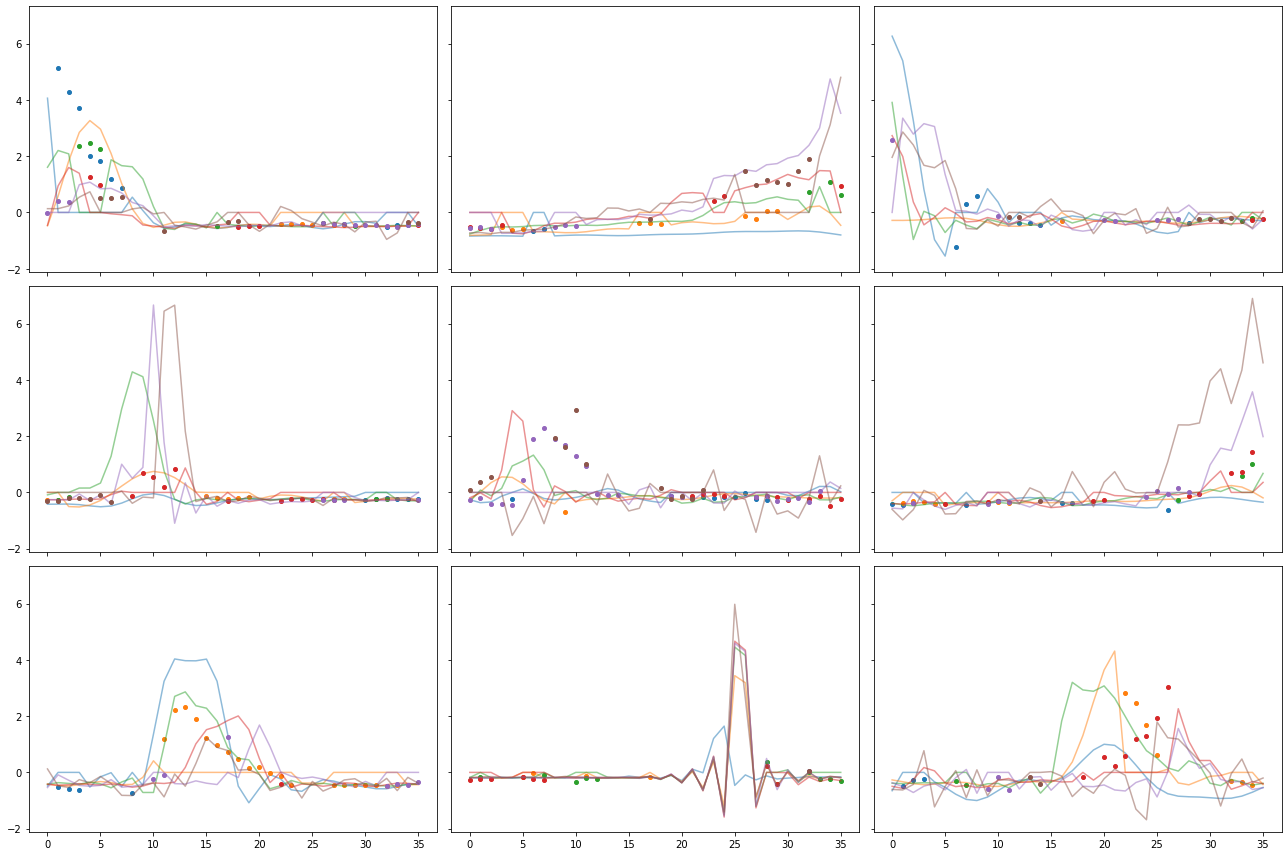

In [ ]:
learn.MVP.show_preds(sharey=True)

# Fine-tune 🎻

There are at least 2 options to use the pretrained model weights: 

1.   Fine-tune
2.   Train


We'll start by fine-tuning the pretrained model.

In this case, we double the base_lr as the training lr will be the base_lr / 2. The only net change of the fine tuning then is just a training of the new head for 10 epochs. The rest of the training will be the same.

Before training though, we'll check that when the model is frozen only the last layer is trained: 

In [ ]:
learn = ts_learner(dls010, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
for p in learn.model.parameters():
    p.requires_grad=False
print(f'{"trainable params once manually frozen":40}: {count_parameters(learn.model):8}')
learn.freeze()
print(f'{"trainable params after learn.freeze()":40}: {count_parameters(learn.model):8}')
learn.unfreeze()
print(f'{"trainable params learn.unfreeze()":40}: {count_parameters(learn.model):8}')

weights from data/MVP/LSST_200.pth successfully transferred!

trainable params once manually frozen   :        0
trainable params after learn.freeze()   :     3854
trainable params learn.unfreeze()       :   457614


It seems to be working well.

9/10 accuracy: 0.607 +/- 0.003
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.655916,2.601593,0.096918,00:00
1,2.620106,2.525911,0.310624,00:00
2,2.572628,2.394981,0.399432,00:00
3,2.498118,2.223824,0.383212,00:00
4,2.415064,2.066213,0.365369,00:00
5,2.338727,1.970221,0.363747,00:00
6,2.265962,1.897584,0.375507,00:00
7,2.198187,1.782391,0.411192,00:00
8,2.116490,1.668513,0.460260,00:00
9,2.045808,1.602330,0.517437,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.439940,1.592649,0.521492,00:00
1,1.445314,1.582950,0.518248,00:00
2,1.425198,1.572848,0.511760,00:00
3,1.436689,1.563972,0.508110,00:00
4,1.437534,1.552648,0.509327,00:00
5,1.418190,1.540048,0.512165,00:00
6,1.404886,1.526588,0.514599,00:00
7,1.395060,1.511242,0.514193,00:00
8,1.387642,1.494751,0.513382,00:00
9,1.373964,1.478487,0.510543,00:00


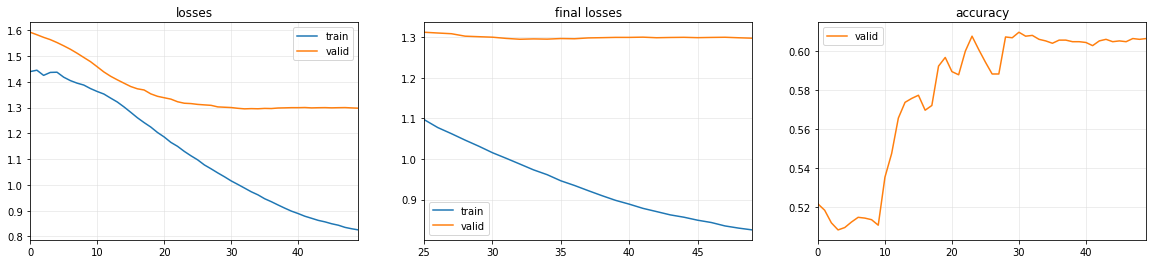


accuracy: 0.607 +/- 0.002 in 10 tests


In [ ]:
# self-supervised: fine-tuning with 10% labels
n_epochs = 50
freeze_epochs = 10
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fine_tune(n_epochs, base_lr=2e-2, freeze_epochs=freeze_epochs)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.711 +/- 0.002
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.419804,2.202557,0.270073,00:00
1,2.130674,1.863494,0.378751,00:00
2,1.875935,1.570243,0.490268,00:00
3,1.632836,1.353105,0.553934,00:00
4,1.424224,1.203183,0.619221,00:00
5,1.271490,1.108204,0.622060,00:00
6,1.156719,1.059198,0.650852,00:00
7,1.069908,1.045776,0.645985,00:00
8,1.006536,0.973741,0.668694,00:00
9,0.957864,0.987825,0.671127,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.859610,0.946410,0.686942,00:01
1,0.845001,0.944392,0.678021,00:01
2,0.839405,0.940573,0.686131,00:01
3,0.832953,0.939115,0.690998,00:01
4,0.825336,0.938165,0.684915,00:01
5,0.825882,0.933137,0.691809,00:01
6,0.818750,0.931789,0.692214,00:01
7,0.805756,0.934002,0.688159,00:01
8,0.804021,0.936076,0.688564,00:01
9,0.797403,0.925508,0.690998,00:01


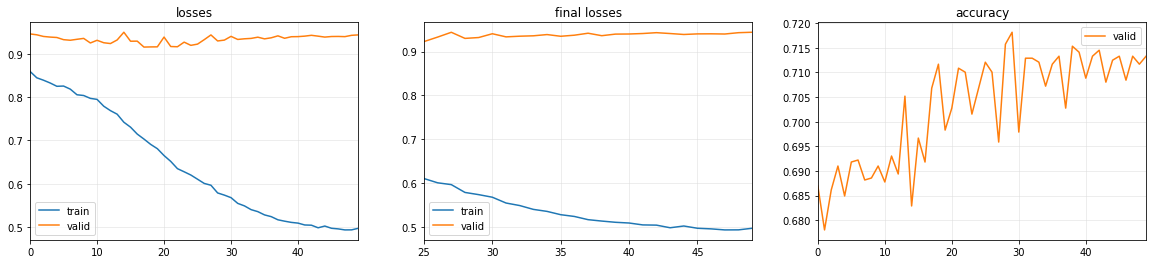


accuracy: 0.711 +/- 0.002 in 10 tests


In [ ]:
# self-supervised: fine-tuning with 100% labels
n_epochs = 50
freeze_epochs = 10
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fine_tune(n_epochs, base_lr=2e-2, freeze_epochs=freeze_epochs)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.705 +/- 0.003
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.423163,2.206140,0.198297,00:00
1,2.144334,1.867992,0.372263,00:00
2,1.879154,1.571531,0.499594,00:00
3,1.639158,1.349702,0.555556,00:00
4,1.430247,1.186743,0.610300,00:00
5,1.263118,1.089227,0.638281,00:00
6,1.148085,1.049662,0.645985,00:00
7,1.060058,0.997592,0.656529,00:00
8,0.990571,0.999692,0.670722,00:00
9,0.951461,0.979454,0.663017,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.838469,0.961584,0.676399,00:01
1,0.842050,0.946087,0.677210,00:01
2,0.843606,0.945821,0.685726,00:01
3,0.836885,0.939733,0.690592,00:01
4,0.833285,0.932846,0.690998,00:01
5,0.815733,0.945342,0.683698,00:01
6,0.806513,0.950220,0.686537,00:01
7,0.796875,0.937599,0.693025,00:01
8,0.780165,0.924691,0.689376,00:01
9,0.769703,0.923613,0.696269,00:01


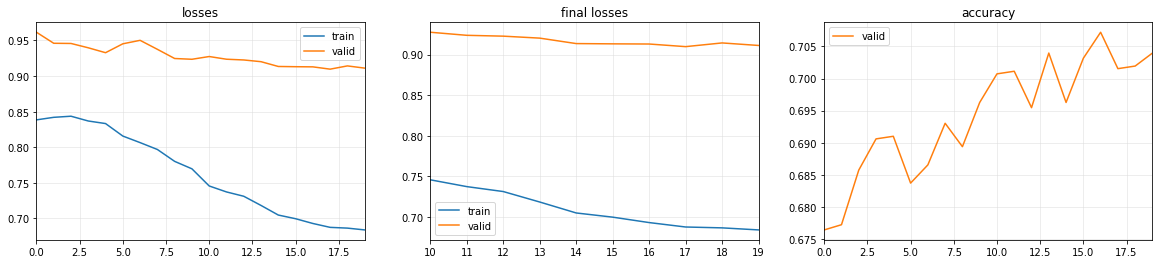


accuracy: 0.705 +/- 0.003 in 10 tests


In [ ]:
# self-supervised: fine-tuning with 100% labels
n_epochs = 20
freeze_epochs = 10
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fine_tune(n_epochs, base_lr=2e-2, freeze_epochs=freeze_epochs)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

# Train 🏃🏽‍♀️🏃🏽‍♀

9/10 accuracy: 0.585 +/- 0.006
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.616868,2.592736,0.113950,00:00
1,2.600036,2.540575,0.245337,00:00
2,2.567896,2.457626,0.345093,00:00
3,2.523066,2.329461,0.392539,00:00
4,2.465010,2.147714,0.424169,00:00
5,2.380981,1.925562,0.434712,00:00
6,2.282300,1.727755,0.450527,00:00
7,2.181931,1.634338,0.490673,00:00
8,2.081217,1.566556,0.523925,00:00
9,1.975217,1.463394,0.562044,00:00


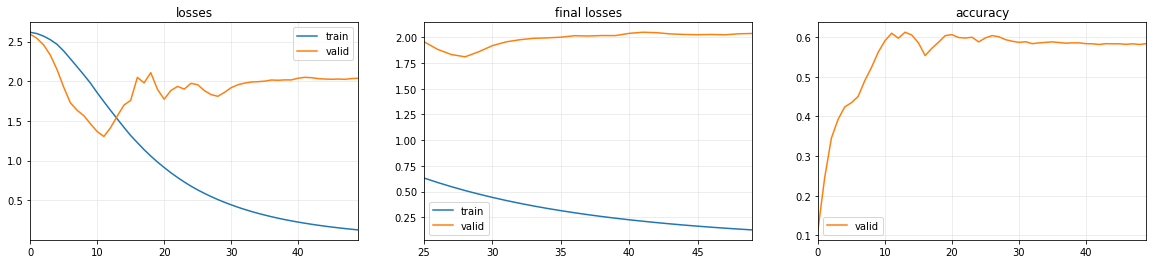


accuracy: 0.585 +/- 0.006 in 10 tests


In [ ]:
# self-supervised: train with 10% labels
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls010, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.720 +/- 0.004
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.411155,2.211255,0.409165,00:01
1,2.096693,1.689680,0.434712,00:01
2,1.734554,1.313863,0.570965,00:01
3,1.408933,1.081416,0.652879,00:01
4,1.177379,0.996753,0.679238,00:01
5,0.990214,0.926244,0.691403,00:01
6,0.858944,0.953108,0.694242,00:01
7,0.755521,1.103257,0.688970,00:01
8,0.694964,1.242100,0.660584,00:01
9,0.629802,0.969543,0.695458,00:01


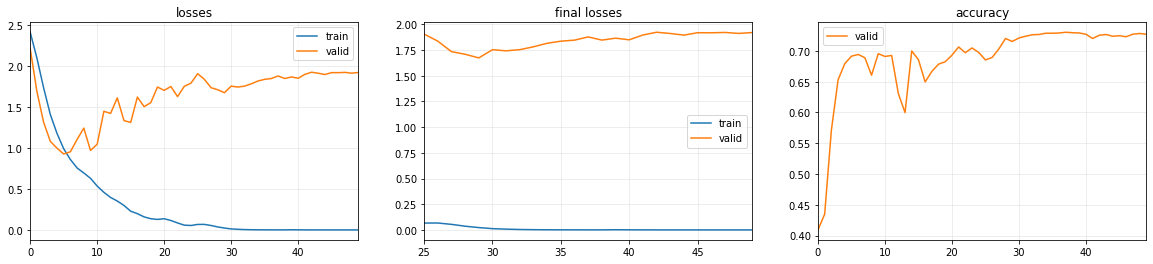


accuracy: 0.721 +/- 0.004 in 10 tests


In [ ]:
# self-supervised: train with 100% labels
n_epochs = 50
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.726 +/- 0.008
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.422630,2.061489,0.388483,00:01
1,1.876750,1.305363,0.560016,00:01
2,1.415515,1.084403,0.643147,00:01
3,1.153992,1.159459,0.581914,00:01
4,0.964313,1.022706,0.696675,00:01
5,0.839616,0.982016,0.686131,00:01
6,0.719349,0.940247,0.696269,00:01
7,0.595666,0.983475,0.700730,00:01
8,0.484704,1.150019,0.711679,00:01
9,0.393088,1.225260,0.686537,00:01


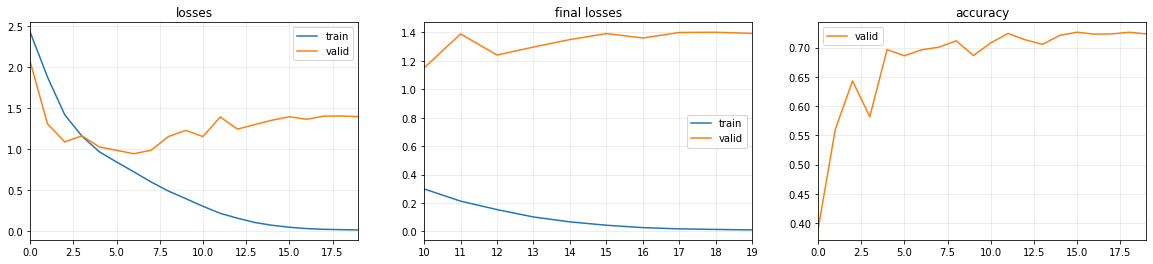


accuracy: 0.726 +/- 0.007 in 10 tests


In [ ]:
# self-supervised 100% + training
n_epochs = 20
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy)
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

# Adding data augmentation 🔎🔎

One last thing I'd like to test is the impact of data augmentation when using a pretrained model. 

I will compare the performance of a model trained from scratch and a pretrained model adding CutMix (CutMix1D in `tsai`). We'll see if the difference in performance still holds.

9/10 accuracy: 0.704 +/- 0.007


epoch,train_loss,valid_loss,accuracy,time
0,2.146854,1.820813,0.376318,00:01
1,1.908568,1.743137,0.463504,00:01
2,1.845235,1.654770,0.370235,00:01
3,1.819277,1.319035,0.616788,00:01
4,1.781973,1.325873,0.557583,00:01
5,1.733254,1.227704,0.586375,00:01
6,1.679481,1.196864,0.617194,00:01
7,1.667700,1.170434,0.649230,00:01
8,1.588408,1.074433,0.640308,00:01
9,1.576984,1.112933,0.671127,00:01


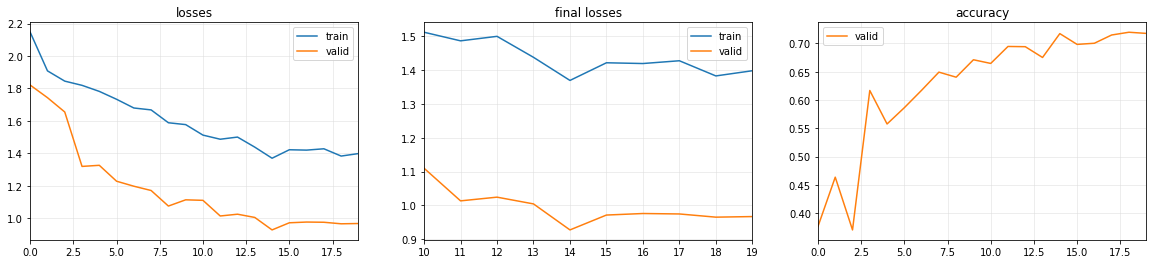


accuracy: 0.705 +/- 0.008 in 10 tests


In [ ]:
# self-supervised 100% + training
n_epochs = 20
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, metrics=accuracy, cbs=CutMix1d())
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

9/10 accuracy: 0.723 +/- 0.004
weights from data/MVP/LSST_200.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,2.453182,2.138275,0.454988,00:01
1,2.143071,1.561368,0.491890,00:01
2,1.867368,1.207138,0.590430,00:01
3,1.762272,1.232091,0.621249,00:01
4,1.676222,1.219177,0.628143,00:01
5,1.624254,1.063735,0.650041,00:01
6,1.569367,1.152449,0.636253,00:01
7,1.553854,1.260472,0.592457,00:01
8,1.548306,0.995081,0.697486,00:01
9,1.532697,1.068211,0.680454,00:01


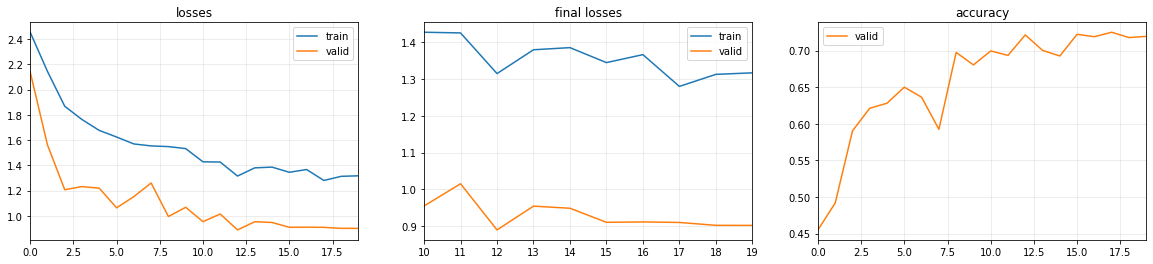


accuracy: 0.723 +/- 0.004 in 10 tests


In [ ]:
# self-supervised 100% + training with cutmix
n_epochs = 20
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls100, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{dsid}_200.pth', metrics=accuracy, cbs=CutMix1d())
    learn.fit_one_cycle(n_epochs, 1e-2)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')

As you can see CutMix improves performance in both cases, but the pretrained model still performs better.

# Conclusions ✅

`MVP` is the first self-supervised method added to the `tsai` library. And it seems to work pretty well. It shows something really interesting: self-supervised learning may improve performance, with or without additional unlabeled data.

In this notebook we've demonstrated how easy it is to use a self-supervised method in 2 steps: 

1. pretrain an architecture using the `MVP` callback.
2. fine-tune or train the same architecture using the pretrained model weights.

In all cases, performance has been better when using the pretrained model weights as a starting point. 

In this case, training has proven to be superior to fine-tuning. However, this will not always be the case. It's difficult to know a priori whether fine/tuning or training will provide better results. I'd recommend trying both approaches. 

In the case of using data augmentation (data augmentation), we've also seen that the pretrained model performs better than the one trained from scratch.

`MVP` has shown it can improve performance with a low number of labels (10%) as well as with all labels (100%). 

I'd encourage you to use `MVP` with your own datasets and share your experience.